In [41]:
import os
import time 
import json

import gtsam

import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance
import matplotlib.pyplot as plt

from nuscenes.can_bus.can_bus_api import NuScenesCanBus
from nuscenes.eval.common.utils import quaternion_yaw
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.nuscenes import NuScenes
import nuscenes.utils.splits as nuscenes_splits

import rosbag2_py
from rosidl_runtime_py.utilities import get_message
from rclpy.serialization import deserialize_message

In [2]:
# Declare parameters
nuscenes_dir = '/home/jd/nuScenes/data'
mcap_dir = '/home/jd/nuscenes2mcap/mcap'
results_dir = '/home/jd/tracking_ws/src/ros_tracking/results'
# dataset_name: 'v1.0-mini'
split_name = 'mini_train'
lidar_detector = 'megvii'
ann_topic = '/annotations'
det_topic = '/detections'

# Weights?
asgn_thresh = 10.0

# Initial spatial covariance
pos_sigma = np.array([1, 1, 1])
pos_cov = np.diag(pos_sigma**2)
pos_cov_inv = np.linalg.inv(pos_cov)
print(pos_cov)
print(pos_cov_inv)

[[1 0 0]
 [0 1 0]
 [0 0 1]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [3]:
# Create ROS objects
reader = rosbag2_py.SequentialReader()

In [4]:
# Member variables
lidar_det_string = "-" + lidar_detector if lidar_detector else ""
match_cols = ['ann_px','ann_py','ann_pz','ann_sx','ann_sy','ann_sz','ann_lbl',
              'det_px','det_py','det_pz','det_sx','det_sy','det_sz','det_lbl','det_conf']

unmatch_trk_cols = ['ann_px','ann_py','ann_pz','ann_sx','ann_sy','ann_sz','ann_lbl']
unmatch_det_cols = ['det_px','det_py','det_pz','det_sx','det_sy','det_sz','det_lbl','det_conf']


# Remap nuScenes class -> tracking class (See https://www.nuscenes.org/tracking/ classes)
tracking_class_map = {"animal": "void_ignore",
                      "human.pedestrian.personal_mobility": "void_ignore",
                     "human.pedestrian.stroller": "void_ignore",
                     "human.pedestrian.wheelchair": "void_ignore",
                     "movable_object.barrier": "void_ignore",
                     "movable_object.debris": "void_ignore",
                     "movable_object.pushable_pullable": "void_ignore",
                     "movable_object.trafficcone": "void_ignore",
                     "static_object.bicycle_rack": "void_ignore",
                     "vehicle.emergency.ambulance": "void_ignore",
                     "vehicle.emergency.police": "void_ignore",
                     "vehicle.construction": "void_ignore",
                     "vehicle.bicycle": "bicycle",
                     "vehicle.bus.bendy": "bus",
                     "vehicle.bus.rigid": "bus",
                     "vehicle.car": "car",
                     "vehicle.motorcycle": "motorcycle",
                     "human.pedestrian.adult": "pedestrian",
                     "human.pedestrian.child": "pedestrian",
                     "human.pedestrian.construction_worker": "pedestrian",
                     "human.pedestrian.police_officer": "pedestrian",
                     "vehicle.trailer": "trailer",
                     "vehicle.truck": "truck"}

# Dataframes
raw_df = pd.DataFrame(columns=match_cols)
match_df = pd.DataFrame(columns=match_cols)
unmatched_det_df = pd.DataFrame(columns=unmatch_det_cols)
unmatched_trk_df = pd.DataFrame(columns=unmatch_trk_cols)

In [5]:
# COMPUTE MATCH

# Main loop - iterate through splits and mcaps
split = eval('nuscenes_splits.' + split_name)

for scene in split: # for scene in split
    print("Processing scene %s" % (scene))

    # Load bag
    storage_options = rosbag2_py.StorageOptions(
        uri="%s/%s%s/%s%s_0.mcap" % (mcap_dir, scene, lidar_det_string, scene, lidar_det_string),
        storage_id='mcap')
    converter_options = rosbag2_py.ConverterOptions('', '')
    reader.open(storage_options, converter_options)
    
    
    # Deal with type names
    topic_types = reader.get_all_topics_and_types()

    def typename(topic_name):
        for topic_type in topic_types:
            if topic_type.name == topic_name:
                return topic_type.type
        raise ValueError(f"topic {topic_name} not in bag")
 
    got_ann = False
    got_det = False
    while reader.has_next():
        
        topic, data, timestamp = reader.read_next()

        if topic==ann_topic:
            # self.get_logger().info("Topic: %s" % (topic))                  

            ann_msg_type = get_message(typename(topic))
            ann_msg = deserialize_message(data, ann_msg_type)
            
            got_ann = True
        
        if topic==det_topic:
            # self.get_logger().info("Topic: %s" % (topic))                  

            det_msg_type = get_message(typename(topic))
            det_msg = deserialize_message(data, det_msg_type)
            
            got_det = True
            
        if got_ann and got_det:
           
            # Compute cost matrix
            n_dets = len(det_msg.entities)
            n_anns = len(ann_msg.entities)
            
            cost_matrix = np.zeros((n_dets,n_anns))
            for ii,det in enumerate(det_msg.entities):
                for jj,trk in enumerate(ann_msg.entities):
                    
                    cost_matrix[ii,jj] = np.linalg.norm([det.cubes[0].pose.position.x - trk.cubes[0].pose.position.x,
                                                         det.cubes[0].pose.position.y - trk.cubes[0].pose.position.y,
                                                         det.cubes[0].pose.position.z - trk.cubes[0].pose.position.z]) - np.log(float(det.metadata[1].value))
#                     cost_matrix[ii,jj] = distance.mahalanobis([det.cubes[0].pose.position.x, det.cubes[0].pose.position.y, det.cubes[0].pose.position.z],
#                                                               [trk.cubes[0].pose.position.x, trk.cubes[0].pose.position.y, trk.cubes[0].pose.position.z],
#                                                               pos_cov_inv) - np.log(float(det.metadata[1].value))
            
            # Solve cost matrix
            # TODO - can reuse assignment.py here
            det_asgn_idx, trk_asgn_idx = linear_sum_assignment(cost_matrix)
            det_asgn_idx, trk_asgn_idx = list(det_asgn_idx), list(trk_asgn_idx)
            
            # If cost above threshold, remove the match from assignment vector
            assert(len(det_asgn_idx) == len(trk_asgn_idx))
            ii = len(det_asgn_idx)
            while ii:
                idx = ii-1
                if cost_matrix[det_asgn_idx[idx],trk_asgn_idx[idx]] > asgn_thresh:
                    del det_asgn_idx[idx], trk_asgn_idx[idx]       
                ii -=1
            assert(len(det_asgn_idx) == len(trk_asgn_idx))
            
            # Handle matches
            for det_idx, trk_idx in zip(det_asgn_idx, trk_asgn_idx):
                
                # match_cols = ['ann_px','ann_py','ann_pz','ann_sx','ann_sy','ann_sz','ann_lbl',
                # 'det_px','det_py','det_pz','det_sx','det_sy','det_sz','det_lbl','det_conf']
                data_df = pd.DataFrame([[ann_msg.entities[trk_idx].cubes[0].pose.position.x, 
                                         ann_msg.entities[trk_idx].cubes[0].pose.position.y,
                                         ann_msg.entities[trk_idx].cubes[0].pose.position.z,
                                         ann_msg.entities[trk_idx].cubes[0].size.x, 
                                         ann_msg.entities[trk_idx].cubes[0].size.y,
                                         ann_msg.entities[trk_idx].cubes[0].size.z,
                                         tracking_class_map[ann_msg.entities[trk_idx].metadata[0].value],
                                         det_msg.entities[det_idx].cubes[0].pose.position.x,
                                         det_msg.entities[det_idx].cubes[0].pose.position.y,
                                         det_msg.entities[det_idx].cubes[0].pose.position.z,
                                         det_msg.entities[det_idx].cubes[0].size.x,
                                         det_msg.entities[det_idx].cubes[0].size.y,
                                         det_msg.entities[det_idx].cubes[0].size.z,
                                         det_msg.entities[det_idx].metadata[0].value,
                                         det_msg.entities[det_idx].metadata[1].value]], columns=match_cols)
                
                match_df = pd.concat([match_df,data_df], axis=0)

            # Handle mismatched annotations
            for i, trk in enumerate(ann_msg.entities):
                if i not in trk_asgn_idx: # If track is unmatched, handle it as a missed detection
                
                    data_df = pd.DataFrame([[ann_msg.entities[i].cubes[0].pose.position.x, 
                                         ann_msg.entities[i].cubes[0].pose.position.y,
                                         ann_msg.entities[i].cubes[0].pose.position.z,
                                         ann_msg.entities[i].cubes[0].size.x, 
                                         ann_msg.entities[i].cubes[0].size.y,
                                         ann_msg.entities[i].cubes[0].size.z,
                                         tracking_class_map[ann_msg.entities[i].metadata[0].value]]], 
                                           columns=unmatch_trk_cols)
                
                    unmatched_trk_df = pd.concat([unmatched_trk_df,data_df], axis=0)
            
            # Handle mismatched detections
            # If det is unmatched, handle it as a false detection
            for i, det in enumerate(det_msg.entities):
                if i not in det_asgn_idx: # If track is unmatched, handle it as a missed detection
                    data_df = pd.DataFrame([[det_msg.entities[i].cubes[0].pose.position.x,
                                         det_msg.entities[i].cubes[0].pose.position.y,
                                         det_msg.entities[i].cubes[0].pose.position.z,
                                         det_msg.entities[i].cubes[0].size.x,
                                         det_msg.entities[i].cubes[0].size.y,
                                         det_msg.entities[i].cubes[0].size.z,
                                         det_msg.entities[i].metadata[0].value,
                                         det_msg.entities[i].metadata[1].value]], 
                                           columns=unmatch_det_cols)
                
                    unmatched_det_df = pd.concat([unmatched_det_df,data_df], axis=0)
            
            
            # Loop control
            got_ann = False
            got_det = False
        

Processing scene scene-0061


/tmp/ipykernel_16147/668477487.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  match_df = pd.concat([match_df,data_df], axis=0)
/tmp/ipykernel_16147/668477487.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unmatched_trk_df = pd.concat([unmatched_trk_df,data_df], axis=0)
/tmp/ipykernel_16147/668477487.py:132: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when 

Processing scene scene-0553
Processing scene scene-0655
Processing scene scene-0757
Processing scene scene-0796
Processing scene scene-1077
Processing scene scene-1094
Processing scene scene-1100


In [6]:
print(match_df.shape)
print(unmatched_det_df.shape)
print(unmatched_trk_df.shape)

(11608, 15)
(15917, 8)
(2416, 7)


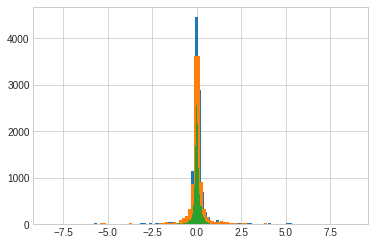

0.02434939557586046
1.4392160083787156
-0.027295775430214077
1.320857552431175
-0.0029345892153881466
0.07043345574085993


In [7]:
delta_x = match_df['ann_px'] - match_df['det_px']
delta_y = match_df['ann_py'] - match_df['det_py']
delta_z = match_df['ann_pz'] - match_df['det_pz']

plt.hist(delta_x.astype(np.float64),100)
plt.hist(delta_y.astype(np.float64),100)
plt.hist(delta_z.astype(np.float64),100)
plt.show()

print(np.mean(delta_x))
print(np.var(delta_x))
print(np.mean(delta_y))
print(np.var(delta_y))
print(np.mean(delta_z))
print(np.var(delta_z))

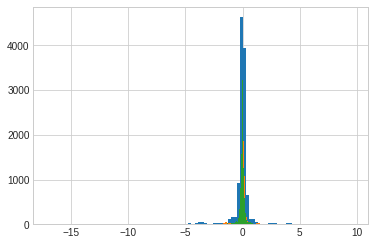

In [8]:
delta_sx = match_df['ann_sx'] - match_df['det_sx']
delta_sy = match_df['ann_sy'] - match_df['det_sy']
delta_sz = match_df['ann_sz'] - match_df['det_sz']

plt.hist(delta_sx.astype(np.float64),100)
plt.hist(delta_sy.astype(np.float64),100)
plt.hist(delta_sz.astype(np.float64),100)
plt.show()

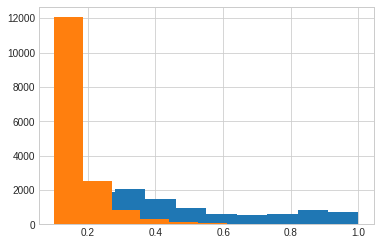

0.16515561904396148
0.006610592494992953
0.4369561585702315
0.06404195386146624
0.0066324876037182475
0.047494622262219725
Discrete Prior
 P( 0 ):
 Choice(0) 
 0 Leaf 0.12253541
 1 Leaf 0.87746459




In [45]:
# plt.hist(delta_x,100)
# plt.hist(delta_y,100)
plt.hist(match_df['det_conf'].astype(np.float64))
plt.hist(unmatched_det_df['det_conf'].astype(np.float64))
plt.show()

# mu_unmatch = np.mean(unmatched_det_df['det_conf'].astype(np.float64))
# sigma_unmatch = np.var(unmatched_det_df['det_conf'].astype(np.float64))
mu_match = np.mean(match_df['det_conf'].astype(np.float64))
sigma_match = np.var(match_df['det_conf'].astype(np.float64))

print(mu_unmatch)
print(sigma_unmatch)
print(mu_match)
print(sigma_match)

x = .2
likelihood_match = np.exp(-(x - mu_match)**2/(2*sigma_match**2))/(np.sqrt(2*np.pi)*sigma_match)
likelihood_unmatch = np.exp(-(x)**2/(2*sigma_match**2))/(np.sqrt(2*np.pi)*sigma_match)
print(likelihood_match)
print(likelihood_unmatch)

p_track = gtsam.DiscreteDistribution([0,2], [likelihood_match, likelihood_unmatch])
print(p_track)

In [10]:
# Form confusion matrix / class-det table
det_classes = list(match_df['det_lbl'].unique())
det_classes.sort()
det_classes.insert(0,'missed_det')
ann_classes = list(match_df['ann_lbl'].unique())
ann_classes.sort()
ann_classes.insert(0,'false_det')

print(ann_classes)
print(det_classes)

['false_det', 'bicycle', 'bus', 'car', 'motorcycle', 'pedestrian', 'trailer', 'truck', 'void_ignore']
['missed_det', 'barrier', 'bicycle', 'bus', 'car', 'construction_vehicle', 'motorcycle', 'pedestrian', 'traffic_cone', 'trailer', 'truck']


In [46]:
conf_df = pd.DataFrame(np.zeros((len(ann_classes),len(det_classes))), columns = det_classes, index=ann_classes,dtype=np.float64)

for index,row in match_df.iterrows():
    conf_df[row['det_lbl']][row['ann_lbl']] +=1
    
# Treat unmatched dets as false det classs
for index,row in unmatched_det_df.iterrows():
    conf_df[row['det_lbl']]['false_det'] +=1

# Treat unmatched tracks as missed dets
for index,row in unmatched_trk_df.iterrows():
    conf_df['missed_det'][row['ann_lbl']] +=1

print(conf_df)

             missed_det  barrier  bicycle    bus     car  \
false_det           0.0   1978.0   1348.0  618.0  3350.0   
bicycle            17.0      9.0    112.0    1.0    12.0   
bus               144.0      0.0      0.0  176.0     8.0   
car              1215.0     36.0     15.0   24.0  3403.0   
motorcycle         29.0      4.0     35.0    1.0     5.0   
pedestrian        482.0     68.0     69.0    9.0    54.0   
trailer             9.0      0.0      0.0    0.0     0.0   
truck             104.0      6.0      0.0    5.0   103.0   
void_ignore       416.0   1978.0     38.0    8.0    85.0   

             construction_vehicle  motorcycle  pedestrian  traffic_cone  \
false_det                   979.0      1099.0      1856.0        1442.0   
bicycle                       0.0         7.0        23.0           0.0   
bus                           4.0         0.0         0.0           0.0   
car                          27.0        45.0        20.0          13.0   
motorcycle              

In [48]:
conf_df = conf_df.div(conf_df.sum(axis=1),axis=0)
print(conf_df)

             missed_det   barrier   bicycle       bus       car  \
false_det      0.000000  0.124270  0.084689  0.038826  0.210467   
bicycle        0.089005  0.047120  0.586387  0.005236  0.062827   
bus            0.390244  0.000000  0.000000  0.476965  0.021680   
car            0.240546  0.007127  0.002970  0.004752  0.673728   
motorcycle     0.136792  0.018868  0.165094  0.004717  0.023585   
pedestrian     0.131802  0.018594  0.018868  0.002461  0.014766   
trailer        0.150000  0.000000  0.000000  0.000000  0.000000   
truck          0.198095  0.011429  0.000000  0.009524  0.196190   
void_ignore    0.105077  0.499621  0.009598  0.002021  0.021470   

             construction_vehicle  motorcycle  pedestrian  traffic_cone  \
false_det                0.061507    0.069046    0.116605      0.090595   
bicycle                  0.000000    0.036649    0.120419      0.000000   
bus                      0.010840    0.000000    0.000000      0.000000   
car                      0.00

# Now, test out using existence probability dist instead of false_det class

In [2]:
prob_class_det = conf_df.data

NameError: name 'conf_df' is not defined